In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
base_dir = r"C:\Users\FAISAL\Desktop\MINORPROJECT\jupyter\dataset_split"   
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

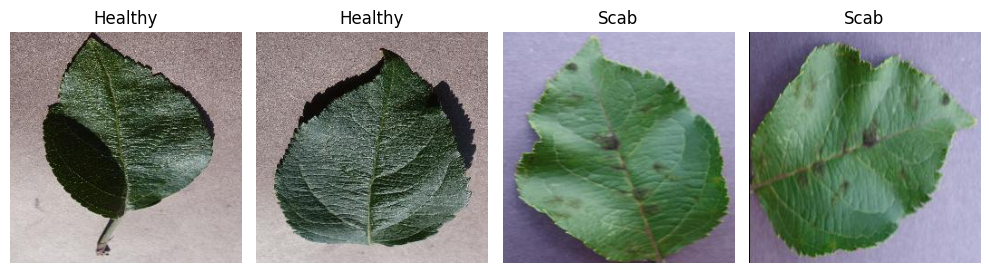

In [3]:
healthy_path = os.path.join(train_dir, 'Apple_Healthy')
scab_path = os.path.join(train_dir, 'Apple_Scab')

# Get first 2 images from each class
healthy_images = os.listdir(healthy_path)[:2]
scab_images = os.listdir(scab_path)[:2]

# Combine all images into a single list for display
all_images = [(img_name, "Healthy") for img_name in healthy_images] + \
             [(img_name, "Scab") for img_name in scab_images]

plt.figure(figsize=(10, 4))  # wider figure for a single row

# Display all 4 images in a single row
for i, (img_name, label) in enumerate(all_images):
    if label == "Healthy":
        img_path = os.path.join(healthy_path, img_name)
    else:
        img_path = os.path.join(scab_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 4, i+1)  # 1 row, 4 columns
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
seed = 42

#  Train data generator — no rotation n
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    #shear_range=0.1,
    zoom_range=0.1,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

# Validation/Test data generator — only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=seed
)

# Validation generator
val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',   
    shuffle=False
)

#  Test generator
test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary', 
    shuffle=False
)


Found 3672 images belonging to 2 classes.
Found 749 images belonging to 2 classes.
Found 759 images belonging to 2 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout, BatchNormalization,
    GlobalAveragePooling2D, Dense
)
from tensorflow.keras.regularizers import l2

# Optimized CNN for weakly supervised apple scab severity estimation
model = Sequential([
    # Input
    tf.keras.Input(shape=(224, 224, 3)),

    # --- Block 1 ---
    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # --- Block 2 ---
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # --- Block 3 ---
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # --- Classifier Head ---
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                        

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
checkpoint_path = r"C:\Users\FAISAL\Desktop\MINORPROJECT\jupyter\best_model_2.h5"
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)
]


In [9]:
history = model.fit(
    train_gen,
    epochs=40,
    validation_data=val_gen,
    callbacks=callbacks,
    workers=4
)


Epoch 1/40
230/230 [==============================] - 35s 128ms/step - loss: 0.2686 - accuracy: 0.9036 - precision: 0.9101 - recall: 0.9044 - val_loss: 1.5335 - val_accuracy: 0.5020 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/40
230/230 [==============================] - 27s 117ms/step - loss: 0.2074 - accuracy: 0.9341 - precision: 0.9364 - recall: 0.9373 - val_loss: 2.3859 - val_accuracy: 0.5087 - val_precision: 1.0000 - val_recall: 0.0134 - lr: 1.0000e-04
Epoch 3/40
230/230 [==============================] - 27s 116ms/step - loss: 0.1972 - accuracy: 0.9398 - precision: 0.9398 - recall: 0.9452 - val_loss: 0.6145 - val_accuracy: 0.7677 - val_precision: 1.0000 - val_recall: 0.5335 - lr: 1.0000e-04
Epoch 4/40
230/230 [==============================] - 27s 117ms/step - loss: 0.1714 - accuracy: 0.9510 - precision: 0.9502 - recall: 0.9561 - val_loss: 0.6274 - val_accuracy: 0.7864 - val_precision: 0.9953 - val_recall: 0.5737 - lr: 1.0000e-04
Epoch 5/40
230/2

48/48 [==============================] - 3s 52ms/step

Classification Report:

               precision    recall  f1-score   support

Apple_Healthy       0.97      1.00      0.99       377
   Apple_Scab       1.00      0.97      0.99       382

     accuracy                           0.99       759
    macro avg       0.99      0.99      0.99       759
 weighted avg       0.99      0.99      0.99       759


Confusion Matrix:
 [[377   0]
 [ 11 371]]


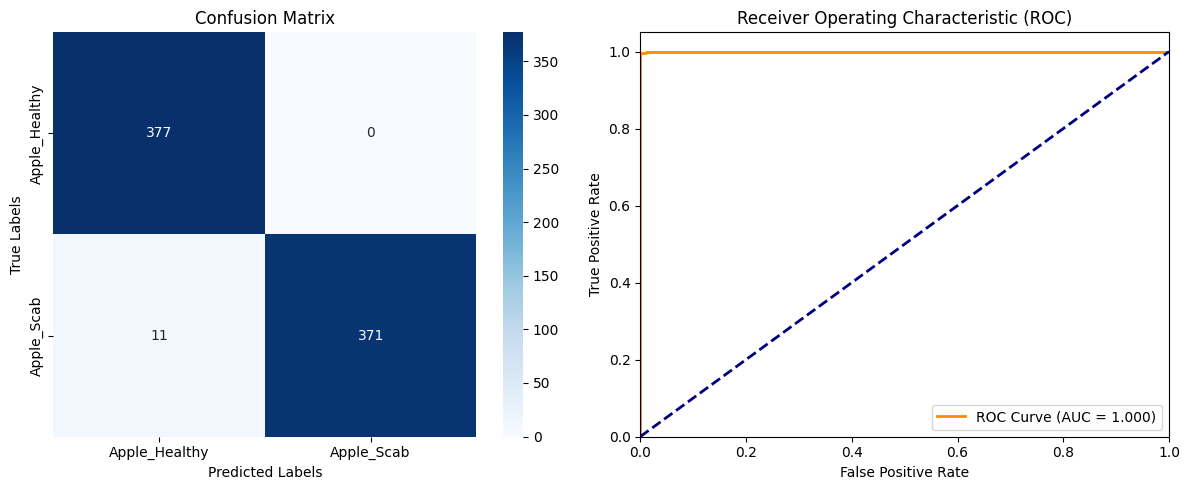

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# --- 🔹 Predict on test set ---
test_steps = test_gen.samples // test_gen.batch_size + 1
preds = model.predict(test_gen, steps=test_steps, verbose=1)

# --- 🔹 Convert probabilities to binary (0 or 1) ---
y_pred = (preds > 0.5).astype(int).ravel()
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# --- 🔹 Print classification metrics ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# --- 🔹 Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# --- 🔹 ROC Curve and AUC ---
y_prob = preds.ravel()  # probabilities for positive class
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# --- 🔹 Combined Plot: Confusion Matrix + ROC Side by Side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

# ROC Curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("Receiver Operating Characteristic (ROC)")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


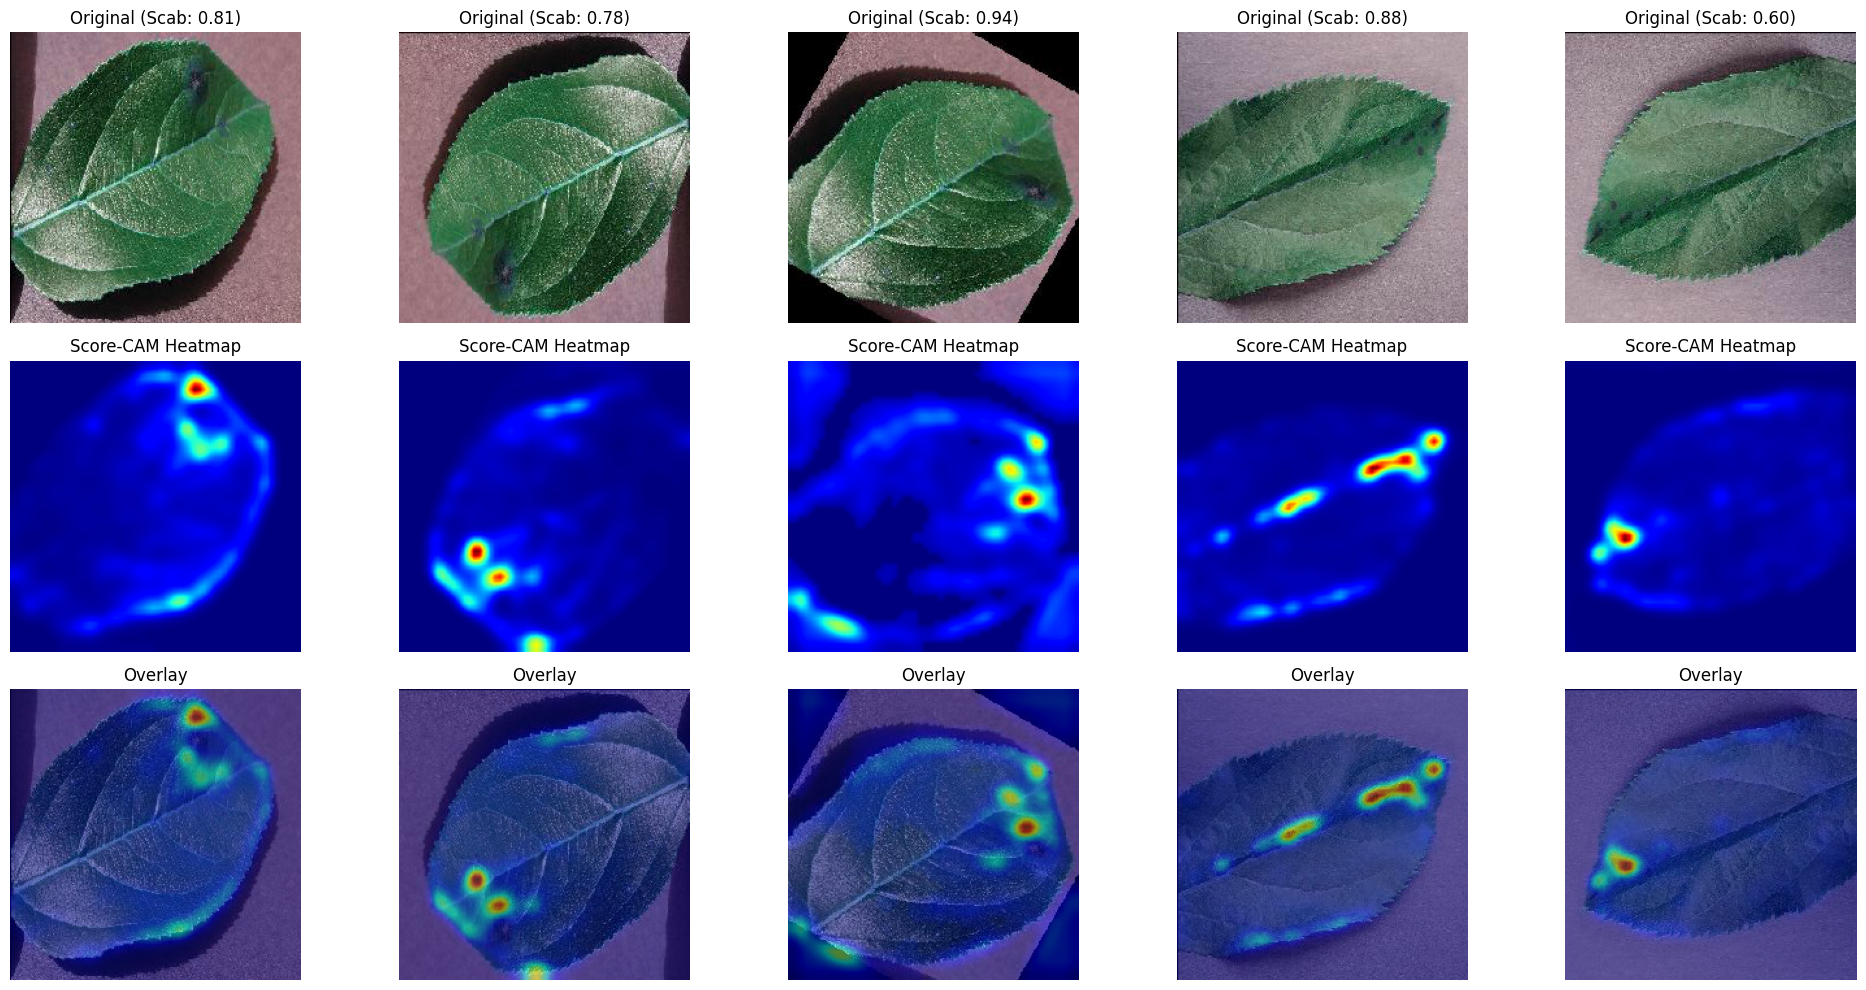

In [229]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# =============================
# 🔥 Score-CAM Implementation
# =============================
def make_scorecam_heatmap(
    img_array,
    model,
    last_conv_layer_name,
    alpha_gamma=3.5,
    blur_ksize=(3, 3),
    percentile_cut=25,
    batch_size=16
):
    """Generates a Score-CAM heatmap focused on scab spots."""
    conv_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output]
    )

    conv_outputs = conv_model(img_array)[0]
    num_channels = conv_outputs.shape[-1]
    input_shape = img_array.shape[1:]
    masked_images = []

    for i in range(num_channels):
        activation_map = conv_outputs[:, :, i]
        norm_map = (activation_map - tf.reduce_min(activation_map)) / (
            tf.reduce_max(activation_map) - tf.reduce_min(activation_map) + 1e-8
        )
        resized_mask = tf.image.resize(
            norm_map[:, :, tf.newaxis], (input_shape[0], input_shape[1])
        )
        masked_images.append(img_array[0] * resized_mask)

    masked_images_batch = tf.stack(masked_images)
    preds = model.predict(masked_images_batch, batch_size=batch_size, verbose=0)
    weights = preds[:, 0]

    weights = tf.reshape(weights, (1, 1, num_channels))
    heatmap = tf.reduce_sum(conv_outputs * weights, axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()

    if blur_ksize:
        heatmap = cv2.GaussianBlur(heatmap, blur_ksize, 0)
    heatmap = np.power(heatmap, alpha_gamma)

    if percentile_cut > 0 and np.max(heatmap) > 0:
        threshold = np.percentile(heatmap, 100 - percentile_cut)
        heatmap = np.where(heatmap >= threshold, heatmap, 0)
        if np.max(heatmap) > 0:
            heatmap = heatmap / np.max(heatmap)

    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    return np.clip(heatmap, 0, 1)


# =============================
# 🔁 Looping display for Scab only
# =============================
def display_scorecam_scab_only(
    test_gen, model, last_conv_layer_name,
    num_images=10, alpha=0.6, alpha_gamma=3.5, blur_ksize=(3,3), percentile_cut=25
):
    """
    Displays Score-CAM only for SCAB predictions.
    Keeps looping batches until enough Scab samples are found.
    """
    shown = 0
    plt.figure(figsize=(num_images * 4, 10))

    while shown < num_images:
        x_batch, _ = next(test_gen)
        preds = model.predict(x_batch, verbose=0)

        for i in range(len(x_batch)):
            pred_scalar = preds[i].item()
            label = "Scab" if pred_scalar >= 0.5 else "Healthy"
            conf = pred_scalar if pred_scalar >= 0.5 else 1 - pred_scalar

            # Skip Healthy predictions
            if label == "Healthy":
                continue

            img = x_batch[i:i+1]

            # Generate Score-CAM
            heatmap = make_scorecam_heatmap(
                img, model, last_conv_layer_name,
                alpha_gamma=alpha_gamma,
                blur_ksize=blur_ksize,
                percentile_cut=percentile_cut
            )

            # Prepare visuals
            original = np.uint8(255 * img[0])
            if original.ndim == 2 or original.shape[-1] == 1:
                original = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)

            heatmap_uint8 = np.uint8(255 * heatmap)
            heatmap_rgb = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(heatmap_rgb, alpha, original, 1 - alpha, 0)

            # Plotting (3 rows per image)
            plt.subplot(3, num_images, shown + 1)
            plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
            plt.title(f"Original ({label}: {conf:.2f})")
            plt.axis("off")

            plt.subplot(3, num_images, shown + 1 + num_images)
            plt.imshow(heatmap, cmap='jet')
            plt.title("Score-CAM Heatmap")
            plt.axis("off")

            plt.subplot(3, num_images, shown + 1 + 2 * num_images)
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title("Overlay")
            plt.axis("off")

            shown += 1
            if shown >= num_images:
                break  # stop once enough scab images are shown

    plt.tight_layout()
    plt.show(block=True)


# =============================
# ✅ Example usage
# =============================
display_scorecam_scab_only(
    test_gen, model,
    last_conv_layer_name='conv2d_5',  # adjust if needed
    num_images=5,
    alpha=0.5,
    alpha_gamma=2.5,
    blur_ksize=(5,5),
    percentile_cut=70
)


In [230]:
#Post-process heatmap → lesion mask

In [ ]:
#Generate a Binary Mask from ScoreCAM Heatmap

Prediction: Scab (0.79)
🟢 Leaf area: 31268 pixels
🔴 Lesion area: 595 pixels
⚠️ Disease Severity: 1.90%


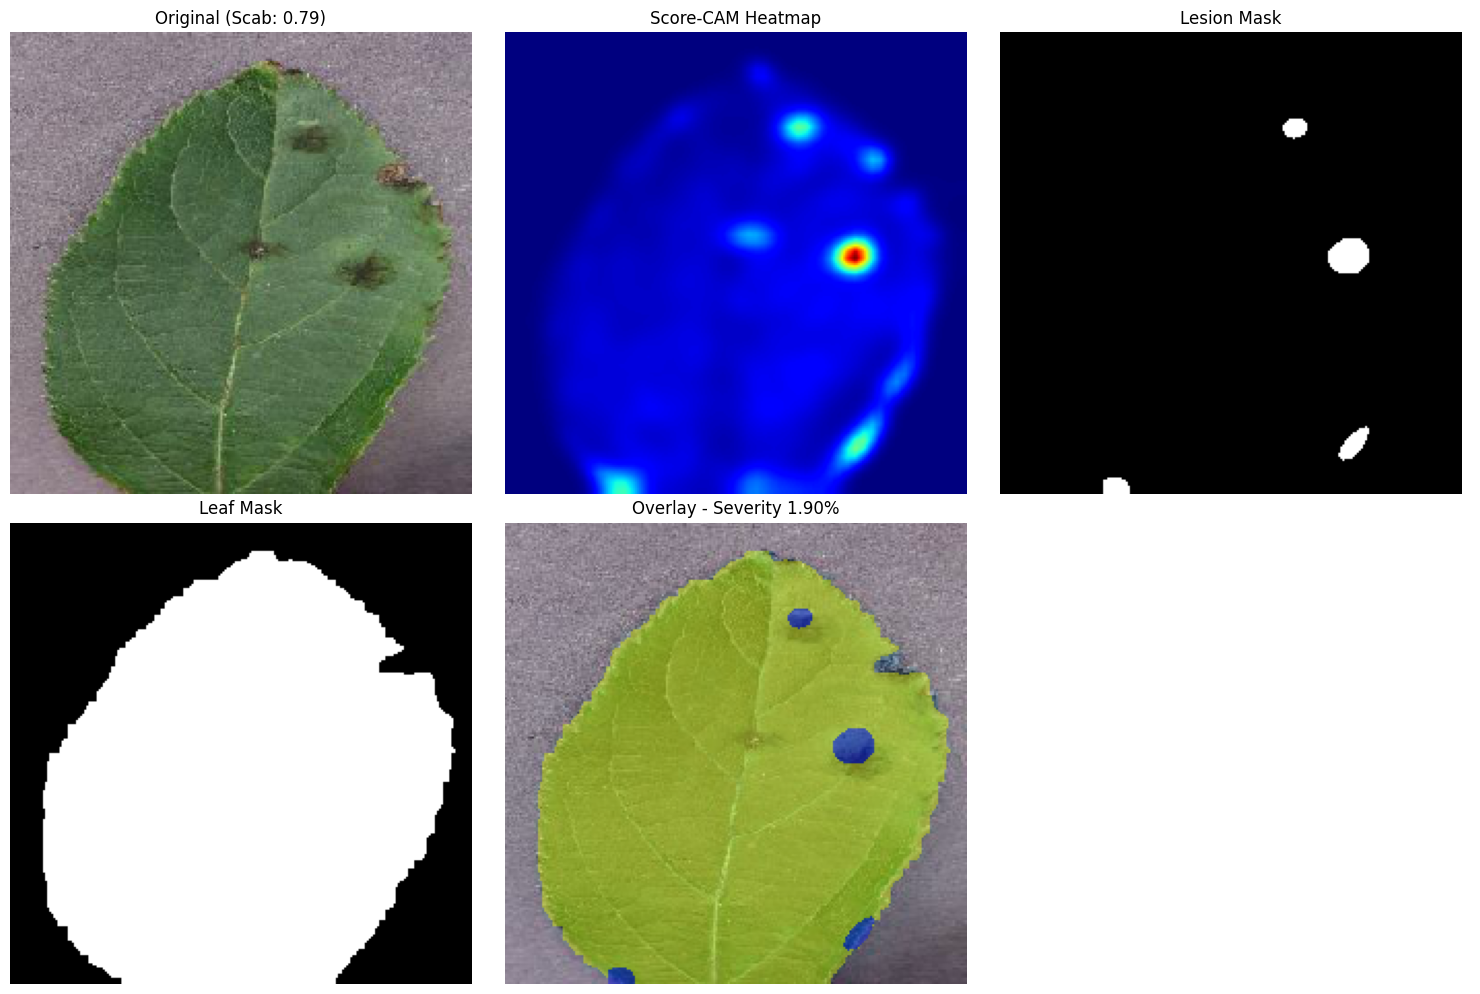

In [301]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# =============================
# --- STEP 0: Prediction ---
# =============================
x_batch, _ = next(test_gen)
img = x_batch[0:1]  # single image

pred = model.predict(img, verbose=0)
pred_scalar = pred.item()
label = "Scab" if pred_scalar >= 0.5 else "Healthy"
conf = pred_scalar if pred_scalar >= 0.5 else 1 - pred_scalar

print(f"Prediction: {label} ({conf:.2f})")

# Skip further processing if healthy
if label == "Healthy":
    print("Leaf is healthy, no further analysis.")
else:
    # =============================
    # --- STEP 1: Heatmap ---
    # =============================
    heatmap = make_scorecam_heatmap(
        img, model,
        last_conv_layer_name='conv2d_5',
        alpha_gamma=2.5,
        blur_ksize=(5,5),
        percentile_cut=70
    )

    # =============================
    # --- STEP 2: Lesion Mask ---
    # =============================
    def heatmap_to_mask(heatmap, method='fixed', fixed_thresh=0.3):
        hm_uint8 = (heatmap * 255).astype(np.uint8)
        if method == 'fixed':
            _, mask = cv2.threshold(hm_uint8, int(fixed_thresh * 255), 255, cv2.THRESH_BINARY)
        elif method == 'otsu':
            _, mask = cv2.threshold(hm_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        else:
            raise ValueError("method must be 'fixed' or 'otsu'")
        return mask // 255

    lesion_mask = heatmap_to_mask(heatmap, method='fixed', fixed_thresh=0.3)

    # =============================
    # --- STEP 3: Leaf Mask ---
    # =============================
    def leaf_segmentation_rgb(image_rgb):
        img = (image_rgb*255).astype(np.uint8) if image_rgb.max() <= 1.0 else image_rgb.astype(np.uint8)
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        lower = np.array([25, 25, 20])
        upper = np.array([100, 255, 255])
        mask = cv2.inRange(hsv, lower, upper)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
        return mask // 255

    def leaf_segmentation_fallback(image_rgb):
        green = (image_rgb[...,1]*255).astype(np.uint8) if image_rgb.max() <= 1.0 else image_rgb[...,1].astype(np.uint8)
        _, mask = cv2.threshold(green, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        return mask // 255

    def get_leaf_mask(image_rgb):
        m = leaf_segmentation_rgb(image_rgb)
        if m.sum() < 50:
            m = leaf_segmentation_fallback(image_rgb)
        return m

    leaf_mask = get_leaf_mask((img[0]*255).astype(np.uint8))

    # =============================
    # --- STEP 4: Severity ---
    # =============================
    lesion_area = lesion_mask.sum()
    leaf_area = leaf_mask.sum()
    severity = (lesion_area / leaf_area) * 100 if leaf_area > 0 else 0

    print(f"🟢 Leaf area: {leaf_area} pixels")
    print(f"🔴 Lesion area: {lesion_area} pixels")
    print(f"⚠️ Disease Severity: {severity:.2f}%")

    # =============================
    # --- STEP 5: Overlay ---
    # =============================
    def overlay_masks(image, lesion_mask, leaf_mask, alpha=0.4):
        img = (image*255).astype(np.uint8) if image.max() <= 1.0 else image.astype(np.uint8)
        overlay = img.copy()
        overlay[lesion_mask==1] = [255, 0, 0]               # lesion red
        overlay[(leaf_mask==1) & (lesion_mask==0)] = [0, 255, 255]  # leaf cyan
        out = cv2.addWeighted(img, 1-alpha, overlay, alpha, 0)
        return out

    overlay_img = overlay_masks(img[0], lesion_mask, leaf_mask, alpha=0.4)

    # =============================
    # --- STEP 6: Plot all together in 2 rows ---
    # =============================
    fig, axes = plt.subplots(2, 3, figsize=(15,10))

    axes[0,0].imshow(np.uint8(img[0]*255))
    axes[0,0].set_title(f"Original ({label}: {conf:.2f})")
    axes[0,0].axis('off')

    axes[0,1].imshow(heatmap, cmap='jet')
    axes[0,1].set_title("Score-CAM Heatmap")
    axes[0,1].axis('off')

    axes[0,2].imshow(lesion_mask, cmap='gray')
    axes[0,2].set_title("Lesion Mask")
    axes[0,2].axis('off')

    axes[1,0].imshow(leaf_mask, cmap='gray')
    axes[1,0].set_title("Leaf Mask")
    axes[1,0].axis('off')

    axes[1,1].imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
    axes[1,1].set_title(f"Overlay - Severity {severity:.2f}%")
    axes[1,1].axis('off')

    axes[1,2].axis('off')  # empty cell

    plt.tight_layout()
    plt.show()


In [278]:
#calculte mean absolute error


Processing High: 100%|█████████████████████████████████████████████████████████████████| 39/39 [00:23<00:00,  1.68it/s]


✅ Best Threshold Found: > 5.0% severity (separates Medium from High)
   (Achieved a 62.50% classification accuracy in the search)

✅ Final Overall Accuracy: 62.50%

--- Classification Report ---
              precision    recall  f1-score   support

      Medium       0.76      0.39      0.52        41
        High       0.58      0.87      0.69        39

    accuracy                           0.62        80
   macro avg       0.67      0.63      0.61        80
weighted avg       0.67      0.62      0.60        80


--- Confusion Matrix ---


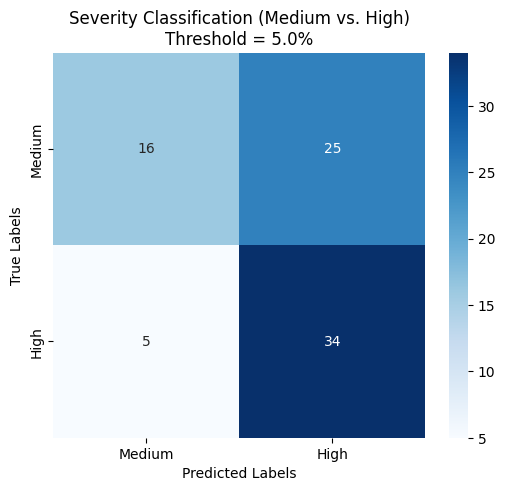

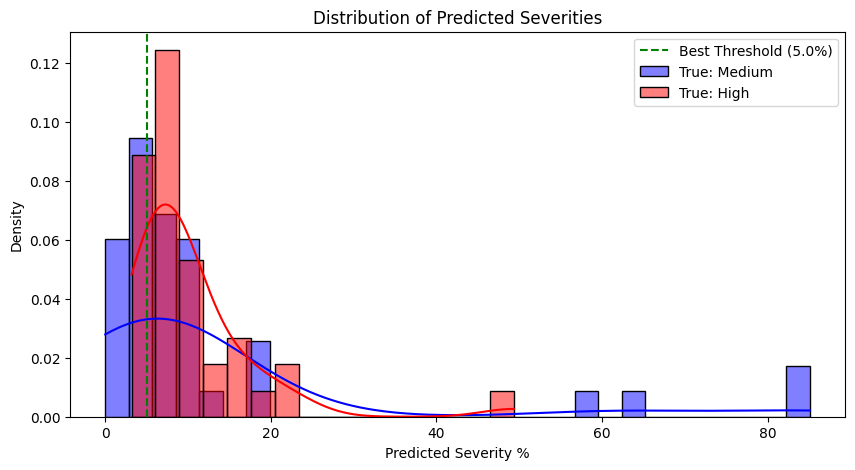

In [297]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error

# --- Settings ---
test_root = "test"  # root folder containing "Medium" and "High"
categories = ["Medium", "High"]
cat2num = {"Medium": 0, "High": 1}
# IMPORTANT: This must be the name of the last Conv2D layer in your model
# You used 'conv2d_5' for the VGG-style model.
conv_layer_name = 'conv2d_5' 

# ==============================
# --- Score-CAM helper ---
# ==============================
def make_scorecam_heatmap(
    img_array,
    model,
    last_conv_layer_name,
    alpha_gamma=3.5,
    blur_ksize=(3, 3),
    percentile_cut=25,
    batch_size=16
):
    """Generates a Score-CAM heatmap focused on scab spots."""
    conv_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output]
    )

    conv_outputs = conv_model(img_array)[0]
    num_channels = conv_outputs.shape[-1]
    input_shape = img_array.shape[1:]
    masked_images = []

    for i in range(num_channels):
        activation_map = conv_outputs[:, :, i]
        norm_map = (activation_map - tf.reduce_min(activation_map)) / (
            tf.reduce_max(activation_map) - tf.reduce_min(activation_map) + 1e-8
        )
        resized_mask = tf.image.resize(
            norm_map[:, :, tf.newaxis], (input_shape[0], input_shape[1])
        )
        masked_images.append(img_array[0] * resized_mask)

    masked_images_batch = tf.stack(masked_images)
    preds = model.predict(masked_images_batch, batch_size=batch_size, verbose=0)
    weights = preds[:, 0]

    weights = tf.reshape(weights, (1, 1, num_channels))
    heatmap = tf.reduce_sum(conv_outputs * weights, axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)
    heatmap = heatmap.numpy()

    if blur_ksize:
        heatmap = cv2.GaussianBlur(heatmap, blur_ksize, 0)
    heatmap = np.power(heatmap, alpha_gamma)

    if percentile_cut > 0 and np.max(heatmap) > 0:
        threshold = np.percentile(heatmap, 100 - percentile_cut)
        heatmap = np.where(heatmap >= threshold, heatmap, 0)
        if np.max(heatmap) > 0:
            heatmap = heatmap / np.max(heatmap)

    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    return np.clip(heatmap, 0, 1)

# ==============================
# --- Leaf mask functions ---
# ==============================
def leaf_segmentation_rgb(image_rgb):
    img = (image_rgb*255).astype(np.uint8) if image_rgb.max() <= 1.0 else image_rgb.astype(np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower = np.array([25, 25, 20])
    upper = np.array([100, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    return mask // 255

def leaf_segmentation_fallback(image_rgb):
    green = (image_rgb[...,1]*255).astype(np.uint8) if image_rgb.max() <= 1.0 else image_rgb[...,1].astype(np.uint8)
    _, mask = cv2.threshold(green, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return mask // 255

def get_leaf_mask(image_rgb):
    mask = leaf_segmentation_rgb(image_rgb)
    if mask.sum() < 50:
        mask = leaf_segmentation_fallback(image_rgb)
    return mask

# ==============================
# --- Main evaluation loop ---
# ==============================
pred_severities, gt_nums = [], []

# --- Heatmap parameters to tune ---
scorecam_params = {
    "alpha_gamma": 2.5,
    "blur_ksize": (5, 5),
    "percentile_cut": 70,
    "batch_size": 16
}

for cat in categories:
    folder_path = os.path.join(test_root, cat)
    for fname in tqdm(os.listdir(folder_path), desc=f"Processing {cat}"):
        img_path = os.path.join(folder_path, fname)
        if not os.path.isfile(img_path):
            continue

        # --- Load and resize ---
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) / 255.0
        img_resized = cv2.resize(img, (224,224))
        img_input = np.expand_dims(img_resized, axis=0).astype(np.float32)

        # --- Step 0: Prediction ---
        pred = model.predict(img_input, verbose=0).item()
        label = "Scab" if pred >= 0.5 else "Healthy"

        if label == "Healthy":
            predicted_severity = 0.0
        else:
            # --- Step 1: Score-CAM heatmap ---
            heatmap = make_scorecam_heatmap(
                img_input, 
                model, 
                conv_layer_name, 
                **scorecam_params
            )

            # --- Step 2: Lesion mask ---
            hm_uint8 = (heatmap*255).astype(np.uint8)
            _, lesion_mask = cv2.threshold(hm_uint8, int(0.3*255), 255, cv2.THRESH_BINARY)
            lesion_mask = lesion_mask // 255

            # --- Step 3: Leaf mask ---
            leaf_mask = get_leaf_mask(img_resized)

            # --- Step 4: Severity ---
            lesion_area = lesion_mask.sum()
            leaf_area = leaf_mask.sum()
            predicted_severity = (lesion_area / leaf_area)*100 if leaf_area>0 else 0

        # --- Store ---
        pred_severities.append(predicted_severity)
        gt_nums.append(cat2num[cat])

# ===============================================
# --- 1. Grid search for best threshold (Optimizing for ACCURACY) ---
# ===============================================
pred_severities = np.array(pred_severities)
gt_nums = np.array(gt_nums)
class_names = ["Medium", "High"]

best_acc = 0.0
best_thresh = 0.0
# Check thresholds from 0.5% to 50% in steps of 0.5
thresholds = np.arange(0.5, 50.0, 0.5) 

for t in thresholds:
    # Classify severities: 0 (Medium) if <= t, 1 (High) if > t
    pred_cats = (pred_severities > t).astype(int)
    
    # Calculate accuracy for this threshold
    acc = accuracy_score(gt_nums, pred_cats)
    
    if acc > best_acc:
        best_acc = acc
        best_thresh = t

print(f"\n✅ Best Threshold Found: > {best_thresh:.1f}% severity (separates Medium from High)")
print(f"   (Achieved a {best_acc*100:.2f}% classification accuracy in the search)")


# ===============================================
# --- 2. Calculate Final Metrics using Best Threshold ---
# ===============================================
# Apply the best threshold to get our final predictions
final_pred_cats = (pred_severities > best_thresh).astype(int)

# Calculate final overall accuracy
overall_acc = accuracy_score(gt_nums, final_pred_cats)
print(f"\n✅ Final Overall Accuracy: {overall_acc*100:.2f}%")


# ===============================================
# --- 3. Display Classification Report & Confusion Matrix ---
# ===============================================
print("\n--- Classification Report ---")
print(classification_report(gt_nums, final_pred_cats, target_names=class_names, zero_division=0))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(gt_nums, final_pred_cats)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f"Severity Classification (Medium vs. High)\nThreshold = {best_thresh:.1f}%")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


# ===============================================
# --- 4. Plot Severity Distributions ---
# ===============================================
plt.figure(figsize=(10, 5))
sns.histplot(pred_severities[gt_nums == 0], color='blue', label='True: Medium', kde=True, stat="density", common_norm=False)
sns.histplot(pred_severities[gt_nums == 1], color='red', label='True: High', kde=True, stat="density", common_norm=False)
plt.axvline(best_thresh, color='green', linestyle='--', label=f'Best Threshold ({best_thresh:.1f}%)')
plt.title("Distribution of Predicted Severities")
plt.xlabel("Predicted Severity %")
plt.ylabel("Density")
plt.legend()
plt.show()